This notebook contains implementation of VAE and Normalizing Flow generative models using FashionMNIST dataset.

Literature:
https://arxiv.org/abs/1605.08803 Density estimation using Real NVP
Laurent Dinh, Jascha Sohl-Dickstein, Samy Bengio

https://arxiv.org/abs/1908.09257 Normalizing Flows: An Introduction and Review of Current Methods
Ivan Kobyzev, Simon J.D. Prince, Marcus A. Brubaker

https://arxiv.org/abs/1906.02691 An Introduction to Variational Autoencoders
Diederik P. Kingma, Max Welling

Imports: We are using PyTorch

In [1]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F

Loading the FashionMNIST dataset locally and saving it.

In [2]:
transform = transforms.ToTensor()

train_dataset = FashionMNIST(
    root='../data', train=True, download=True, transform=transform
)
test_dataset = FashionMNIST(
    root='../data', train=False, download=True, transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

import matplotlib.pyplot as plt
import torchvision

# Get one batch
images, labels = next(iter(train_loader))

# Make a grid of 8x8 images (64 images in one batch)
img_grid = torchvision.utils.make_grid(images[:64], nrow=8, padding=2)

Importing the two models that we are interested in. vae.py and nrm_flow.py have been created and saved in the folder models.

In [3]:
from models.vae import VAE, vae_loss
from models.nrm_flow import AffineCoupling, NormalizingFlowModel


by setting torch.device to cuda, we use the GPU for training our models

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
input_dim  = 28 * 28    # 784
#hidden_dim = 128        # feel free to tweak
#latent_dim = 20         # ditto

In [6]:
vae = VAE(input_dim).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [7]:
for epoch in range(50):
    vae.train()
    total_loss = 0
    for batch, _ in train_loader:
        batch = batch.to(device).view(-1, 28 * 28) 

        recon, mu, logvar = vae(batch)
        MSE, KLD = vae_loss(recon, batch, mu, logvar)
        loss = MSE + KLD
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader.dataset):.4f}")

Epoch 1, Loss: 287.4943
Epoch 2, Loss: 258.7052
Epoch 3, Loss: 252.6473
Epoch 4, Loss: 249.5315
Epoch 5, Loss: 247.8369
Epoch 6, Loss: 246.7757
Epoch 7, Loss: 245.9704
Epoch 8, Loss: 245.4342
Epoch 9, Loss: 244.9882
Epoch 10, Loss: 244.6047
Epoch 11, Loss: 244.2918
Epoch 12, Loss: 244.0427
Epoch 13, Loss: 243.8287
Epoch 14, Loss: 243.6482
Epoch 15, Loss: 243.4424
Epoch 16, Loss: 243.2683
Epoch 17, Loss: 243.1500
Epoch 18, Loss: 243.0422
Epoch 19, Loss: 242.9636
Epoch 20, Loss: 242.7937
Epoch 21, Loss: 242.6858
Epoch 22, Loss: 242.5790
Epoch 23, Loss: 242.4952
Epoch 24, Loss: 242.4649
Epoch 25, Loss: 242.3650
Epoch 26, Loss: 242.3484
Epoch 27, Loss: 242.2130
Epoch 28, Loss: 242.1569
Epoch 29, Loss: 242.0883
Epoch 30, Loss: 242.0620
Epoch 31, Loss: 242.0194
Epoch 32, Loss: 241.9448
Epoch 33, Loss: 241.9104
Epoch 34, Loss: 241.8768
Epoch 35, Loss: 241.8081
Epoch 36, Loss: 241.7630
Epoch 37, Loss: 241.7233
Epoch 38, Loss: 241.6830
Epoch 39, Loss: 241.6980
Epoch 40, Loss: 241.6186
Epoch 41,

In [8]:
with torch.no_grad():
    z = torch.randn(64, 20).to(device)  # 64 samples from N(0, I)
    samples_vae = vae.decode(z).cpu()       # Decode to image space
    samples_vae = samples_vae.view(-1, 1, 28, 28)


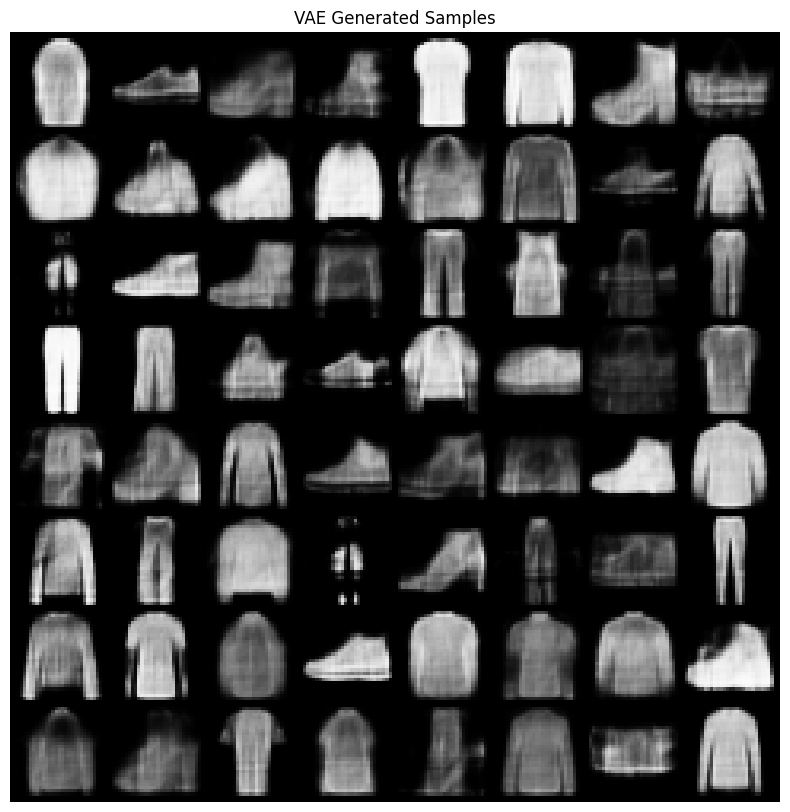

In [9]:
import torchvision
import matplotlib.pyplot as plt

grid = torchvision.utils.make_grid(samples_vae, nrow=8, padding=2)
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.title('VAE Generated Samples')
plt.savefig("vae_generated_samples.png")
plt.show()


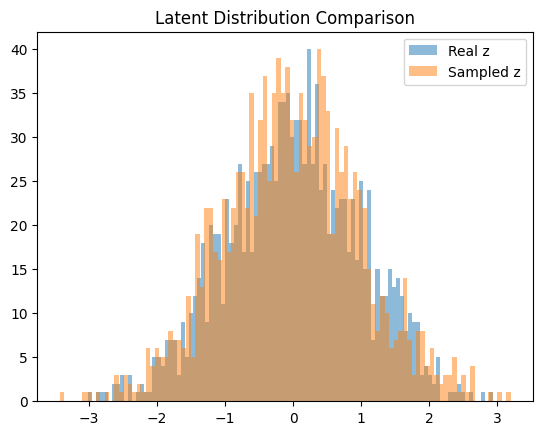

In [10]:
with torch.no_grad():
    x_batch, _ = next(iter(test_loader))
    x_batch = x_batch.to(device).view(-1, 784)
    recon, mu, logvar = vae(x_batch)
    z_real = vae.reparameterize(mu, logvar)
    z_fake = torch.randn_like(z_real)

    real_vals = z_real.detach().cpu().view(-1).numpy()
    fake_vals = z_fake.cpu().view(-1).numpy()

    plt.hist(real_vals, bins=100, alpha=0.5, label='Real z')
    plt.hist(fake_vals, bins=100, alpha=0.5, label='Sampled z')
    plt.legend()
    plt.title('Latent Distribution Comparison')
    plt.show()


Now training Normalizing Flow.

In [11]:
flows = [AffineCoupling(784, 512, swap=(i % 2 == 1)) for i in range(8)]
nf_model = NormalizingFlowModel(flows, input_dim=784).to(device)
optimizer = torch.optim.Adam(nf_model.parameters(), lr=1e-3)

In [12]:
for epoch in range(50):
    total_loss = 0
    for batch, _ in train_loader:
        batch = batch.to(device).view(-1, 784)
        loss = -nf_model.log_prob(batch).mean()  # Negative log likelihood
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")


Epoch 1, Loss: -1044.2189
Epoch 2, Loss: -1291.7350
Epoch 3, Loss: -1358.9094
Epoch 4, Loss: -1399.0520
Epoch 5, Loss: -1429.4671
Epoch 6, Loss: -1451.0678
Epoch 7, Loss: -1469.2428
Epoch 8, Loss: -1481.9221
Epoch 9, Loss: -1493.3693
Epoch 10, Loss: -1504.3977
Epoch 11, Loss: -1513.6163
Epoch 12, Loss: -1520.6049
Epoch 13, Loss: -1528.8866
Epoch 14, Loss: -1535.6307
Epoch 15, Loss: -1540.2718
Epoch 16, Loss: -1544.5985
Epoch 17, Loss: -1552.7378
Epoch 18, Loss: -1555.2649
Epoch 19, Loss: -1560.2731
Epoch 20, Loss: -1563.8256
Epoch 21, Loss: -1568.2815
Epoch 22, Loss: -1570.8817
Epoch 23, Loss: -1575.0053
Epoch 24, Loss: -1577.7784
Epoch 25, Loss: -1582.7931
Epoch 26, Loss: -1586.6320
Epoch 27, Loss: -1588.1511
Epoch 28, Loss: -1588.1889
Epoch 29, Loss: -1589.4254
Epoch 30, Loss: -1594.7947
Epoch 31, Loss: -1595.8513
Epoch 32, Loss: -1598.6028
Epoch 33, Loss: -1600.6109
Epoch 34, Loss: -1602.6346
Epoch 35, Loss: -1604.5424
Epoch 36, Loss: -1607.1414
Epoch 37, Loss: -1605.5442
Epoch 38, 

In [13]:
with torch.no_grad():
    # Sample from base distribution (same dim as input: 784 for 28x28 images)
    z = torch.randn(64, 784).to(device)

    # Invert the flow: z → x
    samples_nf = nf_model.inverse(z).cpu()
    samples_nf = samples_nf.view(-1, 1, 28, 28)
    samples_nf = torch.clamp(samples_nf, 0.0, 1.0)  # optional, for clean visualization


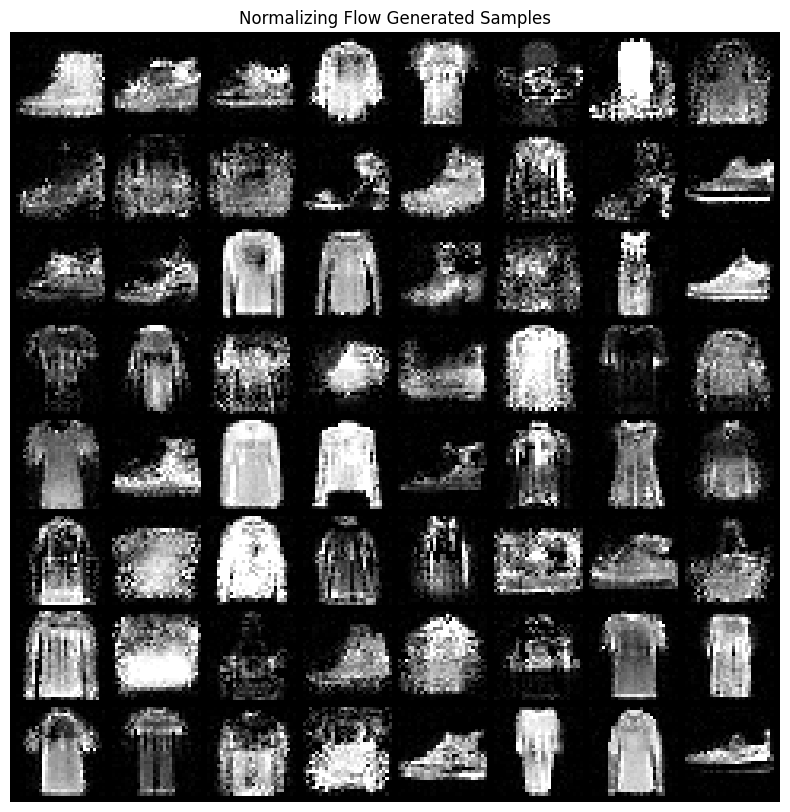

In [14]:
import torchvision
import matplotlib.pyplot as plt

grid = torchvision.utils.make_grid(samples_nf, nrow=8, padding=2)
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.title('Normalizing Flow Generated Samples')
plt.savefig("nf__generated_samples.png")
plt.show()


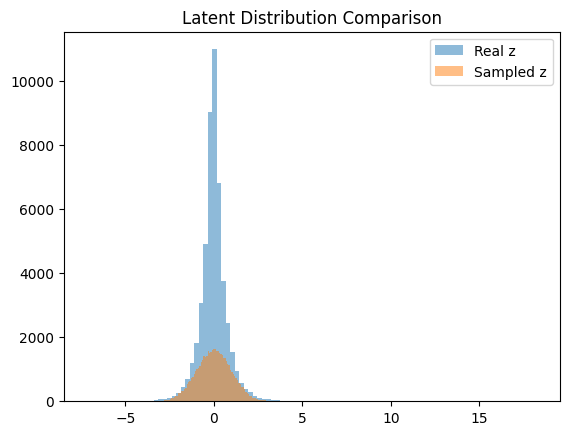

In [15]:
with torch.no_grad():
    x_batch, _ = next(iter(test_loader))
    x_batch = x_batch.to(device).view(-1, 784)
    z_real, _ = nf_model(x_batch)
    z_fake = torch.randn_like(z_real)

    plt.hist(z_real.cpu().view(-1).numpy(), bins=100, alpha=0.5, label='Real z')
    plt.hist(z_fake.cpu().view(-1).numpy(), bins=100, alpha=0.5, label='Sampled z')
    plt.legend()
    plt.title('Latent Distribution Comparison')
    plt.show()


In [16]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from models.nrm_flow import AffineCoupling, NormalizingFlowModel

# ── 1) Hyperparams ─────────────────────────────────────────────────────────────
batch_size     = 128
epochs         = 50
warmup_epochs  = 20      # β ramps 0→1 over these epochs
latent_dim     = 20
hidden_dim     = 512
flow_steps     = 4
learning_rate  = 1e-3
device         = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ── 2) Data ───────────────────────────────────────────────────────────────────
transform = transforms.ToTensor()
train_ds  = FashionMNIST(root="../data", train=True,  download=True, transform=transform)
train_ld  = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  drop_last=True)

# ── 3) VAE Definition ─────────────────────────────────────────────────────────
class VAE(nn.Module):
    def __init__(self, in_dim=784, h=hidden_dim, z=latent_dim):
        super().__init__()
        # encoder
        self.fc1       = nn.Linear(in_dim, h)
        self.fc_mu     = nn.Linear(h, z)
        self.fc_logvar = nn.Linear(h, z)
        # decoder
        self.fc3 = nn.Linear(z, h)
        self.fc4 = nn.Linear(h, in_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        return mu + std * torch.randn_like(std)

    def decode(self, z):
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))    # Bernoulli decoder

    def forward(self, x):
        mu, logvar = self.encode(x)
        z0         = self.reparameterize(mu, logvar)
        return mu, logvar, z0

# ── 4) Flow posterior ──────────────────────────────────────────────────────────
flows = [
    AffineCoupling(latent_dim, hidden_dim, swap=(i % 2 == 1))
    for i in range(flow_steps)
]
flow_post = NormalizingFlowModel(flows, input_dim=latent_dim).to(device)

# ── 5) Instantiate models & optim ────────────────────────────────────────────
vae_flow = VAE().to(device)
opt = torch.optim.Adam(
    list(vae_flow.parameters()) + list(flow_post.parameters()),
    lr=learning_rate
)

# ── 6) Training loop ─────────────────────────────────────────────────────────
for epoch in range(1, epochs+1):
    beta    = min(1.0, epoch / warmup_epochs)
    sum_recon, sum_kl = 0.0, 0.0
    N = len(train_ld.dataset)

    vae_flow.train()
    flow_post.train()
    for imgs, _ in train_ld:
        x = imgs.view(-1, 784).to(device)

        # 1) encode to base Gaussian
        mu, logvar, z0 = vae_flow(x)

        # 2) flow transform
        zK, log_det = flow_post(z0)

        # 3) decode
        x_rec = vae_flow.decode(zK)

        # 4) reconstruction loss (Bernoulli)
        recon = F.binary_cross_entropy(x_rec, x, reduction="sum")

        # 5) KL with flow:
        # log q0(z0|x)
        log_q0  = (-0.5 * ((z0 - mu)**2 / logvar.exp() + logvar + math.log(2*math.pi))).sum(dim=1)
        # log p(zK)
        log_pzk = (-0.5 * (zK**2 + math.log(2*math.pi))).sum(dim=1)
        # full KL
        kl = (log_q0 - log_pzk - log_det).sum()

        # 6) total loss
        loss = recon + beta * kl

        opt.zero_grad()
        loss.backward()
        opt.step()

        sum_recon += recon.item()
        sum_kl    += kl.item()

    print(f"Epoch {epoch:02d} β={beta:.2f} | Recon={sum_recon/N:6.3f} | KL={sum_kl/N:6.3f}")


Epoch 01 β=0.05 | Recon=253.629 | KL=75.969
Epoch 02 β=0.10 | Recon=224.770 | KL=49.596
Epoch 03 β=0.15 | Recon=220.703 | KL=40.406
Epoch 04 β=0.20 | Recon=219.192 | KL=36.155
Epoch 05 β=0.25 | Recon=218.544 | KL=33.360
Epoch 06 β=0.30 | Recon=218.301 | KL=31.195
Epoch 07 β=0.35 | Recon=218.334 | KL=29.373
Epoch 08 β=0.40 | Recon=218.542 | KL=27.778
Epoch 09 β=0.45 | Recon=218.720 | KL=26.378
Epoch 10 β=0.50 | Recon=219.009 | KL=25.099
Epoch 11 β=0.55 | Recon=219.284 | KL=23.963
Epoch 12 β=0.60 | Recon=219.668 | KL=22.929
Epoch 13 β=0.65 | Recon=220.075 | KL=22.014
Epoch 14 β=0.70 | Recon=220.397 | KL=21.117
Epoch 15 β=0.75 | Recon=220.778 | KL=20.334
Epoch 16 β=0.80 | Recon=221.211 | KL=19.605
Epoch 17 β=0.85 | Recon=221.560 | KL=18.967
Epoch 18 β=0.90 | Recon=221.875 | KL=18.317
Epoch 19 β=0.95 | Recon=222.367 | KL=17.741
Epoch 20 β=1.00 | Recon=222.645 | KL=17.202
Epoch 21 β=1.00 | Recon=222.622 | KL=17.045
Epoch 22 β=1.00 | Recon=222.561 | KL=16.941
Epoch 23 β=1.00 | Recon=222.521 

In [17]:
with torch.no_grad():
    z = torch.randn(64, 20).to(device)  # 64 samples from N(0, I)
    samples_vae = vae_flow.decode(z).cpu()       # Decode to image space
    samples_vae = samples_vae.view(-1, 1, 28, 28)


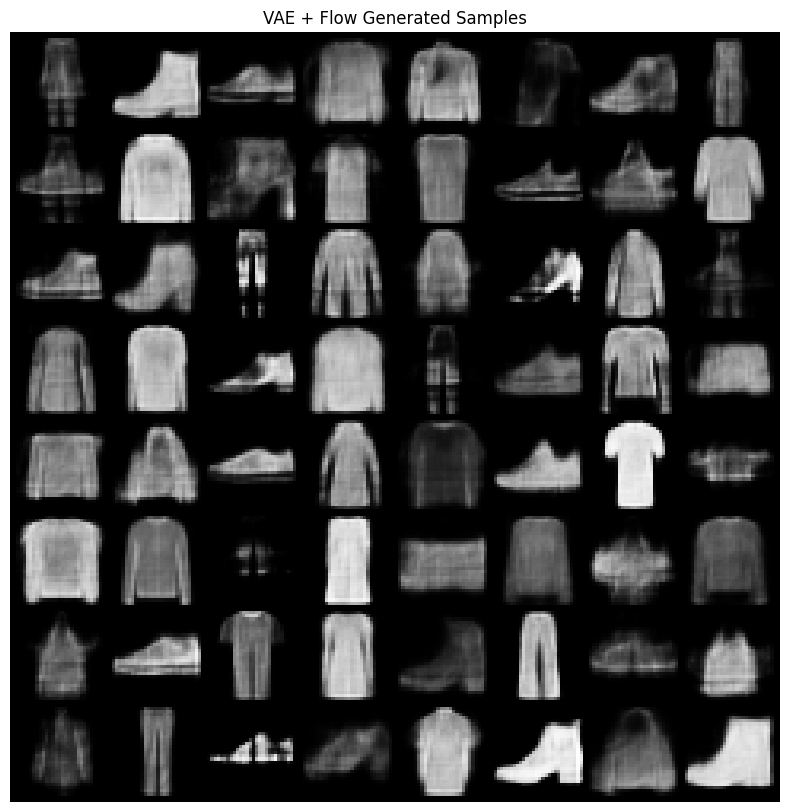

In [18]:
import torchvision
import matplotlib.pyplot as plt

grid = torchvision.utils.make_grid(samples_vae, nrow=8, padding=2)
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.title('VAE + Flow Generated Samples')
plt.savefig("vae_and_flow_generated_samples.png")
plt.show()


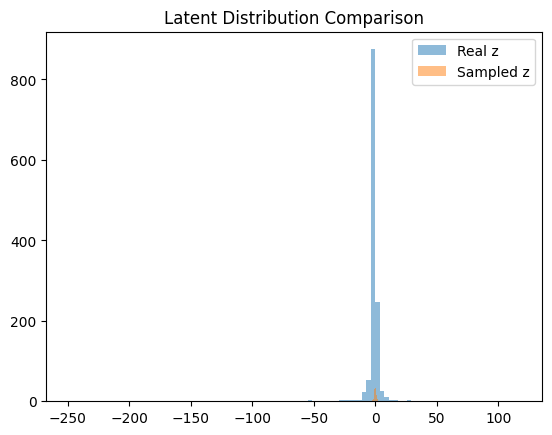

In [19]:
with torch.no_grad():
    x_batch, _ = next(iter(test_loader))
    x_batch = x_batch.to(device).view(-1, 784)
    recon, mu, logvar = vae_flow(x_batch)
    z_real = vae.reparameterize(mu, logvar)
    z_fake = torch.randn_like(z_real)

    real_vals = z_real.detach().cpu().view(-1).numpy()
    fake_vals = z_fake.cpu().view(-1).numpy()

    plt.hist(real_vals, bins=100, alpha=0.5, label='Real z')
    plt.hist(fake_vals, bins=100, alpha=0.5, label='Sampled z')
    plt.legend()
    plt.title('Latent Distribution Comparison')
    plt.show()